In [57]:
# Import modules
import numpy as np
import pandas as pd
import quandl
from itertools import combinations
from datetime import datetime
from datetime import timedelta


from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

# Plotting preferences
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import string
import re

# EDA

In [67]:
#Reading google play store data

df = pd.read_csv('google-play-store-apps/googleplaystore.csv')

reviews = pd.read_csv('google-play-store-apps/googleplaystore_user_reviews.csv')

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
App               10841 non-null object
Category          10841 non-null object
Rating            9367 non-null float64
Reviews           10841 non-null object
Size              10841 non-null object
Installs          10841 non-null object
Type              10840 non-null object
Price             10841 non-null object
Content Rating    10840 non-null object
Genres            10841 non-null object
Last Updated      10841 non-null object
Current Ver       10833 non-null object
Android Ver       10838 non-null object
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [66]:
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [69]:
#Checking to see if there are any apps duplicated in the dataset 

print(any(df['App'].duplicated()))

True


In [70]:
#Dropping duplicated apps 

df = df.drop_duplicates('App')

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9660 entries, 0 to 10840
Data columns (total 13 columns):
App               9660 non-null object
Category          9660 non-null object
Rating            8197 non-null float64
Reviews           9660 non-null object
Size              9660 non-null object
Installs          9660 non-null object
Type              9659 non-null object
Price             9660 non-null object
Content Rating    9659 non-null object
Genres            9660 non-null object
Last Updated      9660 non-null object
Current Ver       9652 non-null object
Android Ver       9657 non-null object
dtypes: float64(1), object(12)
memory usage: 1.0+ MB


In [72]:
#Checking for null values

df.isnull().sum()

App                  0
Category             0
Rating            1463
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

In [73]:
#Dropping any null values of ratings from the dataset
df=df.dropna()
df.shape

(8190, 13)

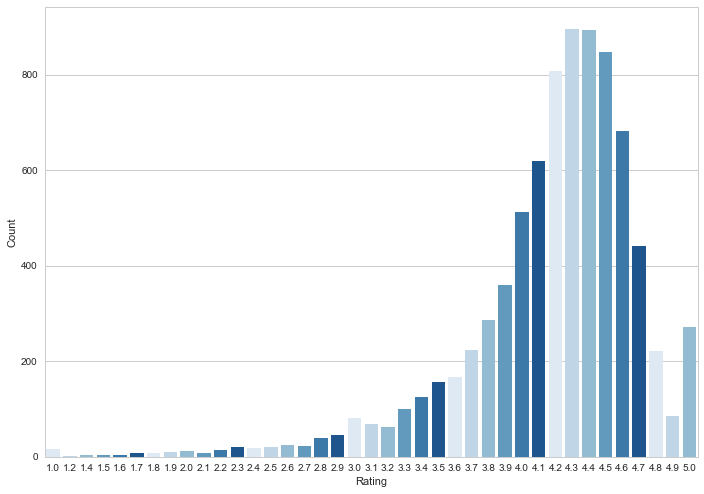

In [92]:
# Displaying the Rating frequency of the apps

sns.set(rc={'figure.figsize': (11.7, 8.27)})
sns.set_style('whitegrid')
ax = sns.countplot(x='Rating', data=df, palette=sns.color_palette('Blues'))
ax.set(xlabel='Rating', ylabel='Count')
plt.show()

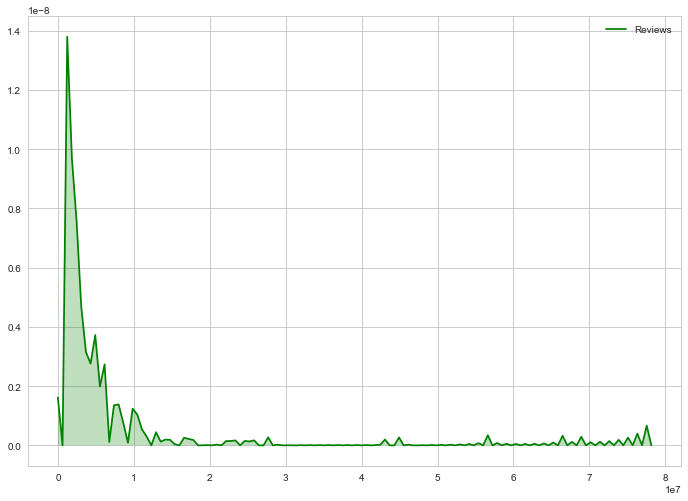

In [99]:
# Number of reviws per app KDE distribution

ax = sns.kdeplot(df['Reviews'], shade=True, color='green')
plt.show()

# Simple Recommender

In [74]:
#Converting reviews and ratings to float type 

df["Reviews"] = pd.to_numeric(df.Reviews, errors='coerce')

df["Rating"] = pd.to_numeric(df.Rating,errors='coerce')

In [75]:
#Calculating the mean rating for the apps in the Play Store

C = df['Rating'].mean()

print(C)

4.17332112332


The mean rating of an app is 4.17 on a scale of 5. 

In [76]:
#Calculating number of reviews per app that lie in the 80th percentile 

m = df['Reviews'].quantile(0.80)

print(m)

75377.8


In [77]:
#Filtering out the apps based on the number of reviews 

filt_df = df.copy().loc[df['Reviews']>=m]

filt_df.shape

(1638, 13)

In [78]:
df.shape

(8190, 13)

As we can see from the above two datasets, the filtered dataset containing apps that only like in the 80th or greater percentile are around 1600, while the total number of apps in the play store are 8k. We next move on to getting out weighted metric for calculating the score for each app

In [79]:
# Function that computes the weighted rating of each app
def weighted_rating(x, m=m, C=C):
    v = x['Reviews']
    R = x['Rating']
    # Calculation based on the formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [80]:
# Define a new feature 'score' and calculate its value with the above function
filt_df['score'] = filt_df.apply(weighted_rating, axis=1)

In [83]:
filt_df.head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,score
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up,4.456275
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up,4.415387
18,FlipaClip - Cartoon animation,ART_AND_DESIGN,4.3,194216,39M,"5,000,000+",Free,0,Everyone,Art & Design,"August 3, 2018",2.2.5,4.0.3 and up,4.264581
19,ibis Paint X,ART_AND_DESIGN,4.6,224399,31M,"10,000,000+",Free,0,Everyone,Art & Design,"July 30, 2018",5.5.4,4.1 and up,4.492713
42,Textgram - write on photos,ART_AND_DESIGN,4.4,295221,Varies with device,"10,000,000+",Free,0,Everyone,Art & Design,"July 30, 2018",Varies with device,Varies with device,4.353895


In [84]:
#Sorting the dataframe based on the aboves calculated scores

filt_df = filt_df.sort_values('score', ascending=False)


In [85]:
#Print the top 15 apps
filt_df[['App', 'Rating', 'Reviews', 'score']].head(15)

,App,Rating,Reviews,score
9625,JW Library,4.9,922752,4.845122
1360,Period Tracker - Period Calendar Ovulation Tra...,4.8,4559407,4.789808
4038,"DU Recorder – Screen Recorder, Video Editor, Live",4.8,2588730,4.782269
4073,Eternium,4.8,1506783,4.770144
4799,PewDiePie's Tuber Simulator,4.8,1499466,4.770005
6707,Vlogger Go Viral - Tuber Game,4.8,1304467,4.765766
2571,Amino: Communities and Chats,4.8,1259075,4.764601
1260,Six Pack in 30 Days - Abs Workout,4.9,272337,4.742470
1361,Period Tracker Clue: Period and Ovulation Tracker,4.8,570242,4.726834
1820,"Cash, Inc. Money Clicker Game & Business Adven...",4.8,549720,4.724432


In [52]:
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159.0,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967.0,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510.0,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644.0,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967.0,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


The above recommender system is an example of a simple app recommender, which retrieves the top 15 apps based on a weighted calculated score, based on the app rating and reviews. 

# Collaborative-Filtering Based Recommender

In [102]:
# Setting up the model

# Recommend 20 similar items
engine = KNeighborsClassifier(n_neighbors=20)

# Training data points
data_points = filt_df[['Rating', 'Reviews', 'score']].values

#Training labels
labels = filt_df.index.values

print("Data points: ")
print(data_points)
print("Labels: ")
print(labels)

engine.fit(data_points, labels)

Data points: 
[[  4.90000000e+00   9.22752000e+05   4.84512191e+00]
 [  4.80000000e+00   4.55940700e+06   4.78980801e+00]
 [  4.80000000e+00   2.58873000e+06   4.78226886e+00]
 ..., 
 [  3.30000000e+00   3.55837000e+05   3.45265947e+00]
 [  3.30000000e+00   3.81023000e+05   3.44423512e+00]
 [  2.80000000e+00   1.07441000e+05   3.36623238e+00]]
Labels: 
[9625 1360 4038 ..., 4763 6327 5233]


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform')

In [107]:
#Setting app name as index of the dataframe

filt_df = filt_df.set_index('App')

In [112]:
# Enter app name to get a list of 20 recommended items

# User entered value
app_name = 'Eternium'

app_data = [filt_df.loc[app_name][['Rating','Reviews','score']].values]

recommended_apps = engine.kneighbors(X=app_data, n_neighbors=20, return_distance=False)

# List of app names form the indexes

apps_list = []

for each in recommended_apps:
    apps_list.append(filt_df.iloc[each].index)

print("Recommended apps: ")
print(apps_list)


Recommended apps: 
[Index([u'Eternium', u'WPS Office - Word, Docs, PDF, Note, Slide & Sheet',
       u'Five Nights at Freddy's 2 Demo', u'CamScanner - Phone PDF Creator',
       u'PewDiePie's Tuber Simulator',
       u'My Airtel-Online Recharge, Pay Bill, Wallet, UPI', u'Helix Jump',
       u'LINE Camera - Photo editor', u'Photo Effects Pro',
       u'Photo Editor Collage Maker Pro', u'Path', u'Photo Editor by Aviary',
       u'Evernote – Organizer, Planner for Notes & Memos',
       u'Best Fiends - Free Puzzle Game', u'Bowmasters',
       u'Photo Lab Picture Editor: face effects, art frames',
       u'DEAD TARGET: FPS Zombie Apocalypse Survival Games',
       u'Star Wars™: Galaxy of Heroes', u'Madden NFL Football',
       u'The Weather Channel: Rain Forecast & Storm Alerts'],
      dtype='object', name=u'App')]


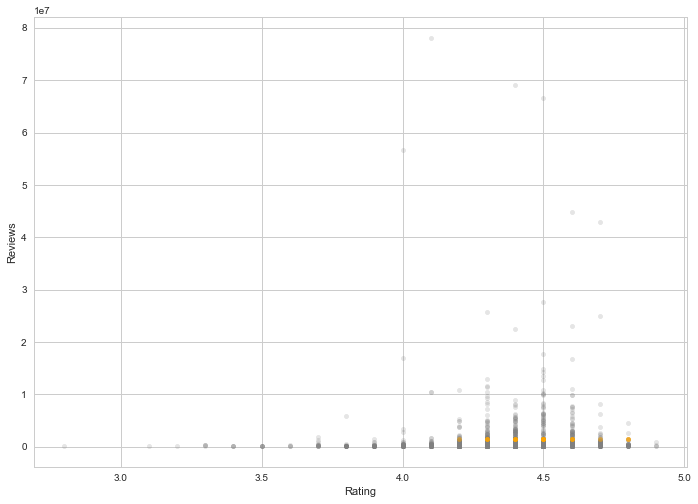

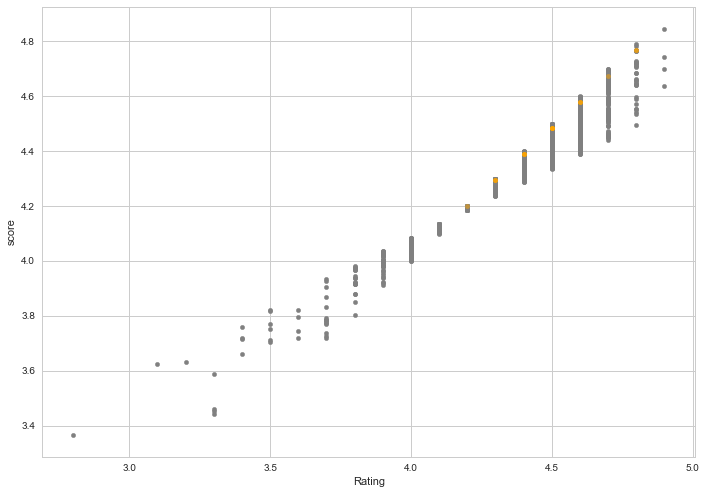

In [113]:
# Showing recommended apps

ax = filt_df.plot(kind='scatter', x='Rating', y='Reviews', color='grey', alpha=0.20)
filt_df.iloc[recommended_apps[0]].plot(kind='scatter', x='Rating', y='Reviews',\
                                                   color='orange', alpha=0.5, ax=ax)

ax2 = filt_df.plot(kind='scatter', x='Rating', y='score', color='grey')
filt_df.iloc[recommended_apps[0]].plot(kind='scatter', x='Rating', y='score',\
                                                   color='orange', alpha=0.5, ax=ax2)


plt.show()

# Content Based Recommender 

This type of a recommender system will recommend apps that are similar to a particular app. In order to do so, we shall compute the pairwise similarity scores for all the apps based on their category, and recommend corresponding apps based on the computed score. 

In [118]:
df['Category'].head()

0    ART_AND_DESIGN
1    ART_AND_DESIGN
2    ART_AND_DESIGN
3    ART_AND_DESIGN
4    ART_AND_DESIGN
Name: Category, dtype: object

In [119]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
df['Category'] = df['Category'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df['Category'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(8190, 33)

In [120]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [121]:
#Construct a reverse map of indices and app titles
indices = pd.Series(df.index, index=df['App']).drop_duplicates()

In [136]:
# Function that takes in app title as input and outputs most similar app
def get_recommendations(app, cosine_sim=cosine_sim):
    # Get the index of the app that matches the title
    idx = indices[app]

    # Get the pairwsie similarity scores of all apps with that app
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the apps based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar apps
    sim_scores = sim_scores[1:26]

    # Get the app indices
    app_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar apps
    return df['App'].iloc[app_indices]

In [137]:
get_recommendations('Infinite Painter')

1                                   Coloring book moana
2     U Launcher Lite – FREE Live Cool Themes, Hide ...
3                                 Sketch - Draw & Paint
4                 Pixel Draw - Number Art Coloring Book
5                            Paper flowers instructions
6               Smoke Effect Photo Maker - Smoke Editor
7                                      Infinite Painter
8                                  Garden Coloring Book
9                         Kids Paint Free - Drawing Fun
10                              Text on Photo - Fonteee
11              Name Art Photo Editor - Focus n Filters
12                       Tattoo Name On My Photo Editor
13                                Mandala Coloring Book
14      3D Color Pixel by Number - Sandbox Art Coloring
15         Photo Designer - Write your name with shapes
16                             350 Diy Room Decor Ideas
17                        FlipaClip - Cartoon animation
18                                         ibis 

In [138]:
#Improving the above recommender system by incorporating a popularity filter - based on ratings and reviews for the
# top 30 most similar apps. This filters out the top 10 apps most similar to the given app along with being the 
# highest rated with most reviews as well. 

def improved_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    app_indices = [i[0] for i in sim_scores]
    
    apps = df.iloc[app_indices][['App', 'Rating', 'Reviews']]
    rating = apps[apps['Rating'].notnull()]['Rating'].astype('int')
    reviews = apps[apps['Reviews'].notnull()]['Reviews'].astype('int')
    C = rating.mean()
    m = reviews.quantile(0.60)
    qual = apps[(apps['Reviews'] >= m) & (apps['Rating'].notnull())]
    qual['Rating'] = qual['Rating'].astype('int')
    qual['Reviews'] = qual['Reviews'].astype('int')
    qual['score'] = qual.apply(weighted_rating, axis=1)
    qual = qual.sort_values('score', ascending=False).head(10)
    return qual

In [139]:
improved_recommendations('Infinite Painter')

/Users/sirishat/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sirishat/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sirishat/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

,App,Rating,Reviews,score
11,Name Art Photo Editor - Focus n Filters,4,8788,4.155224
8,Garden Coloring Book,4,13791,4.146515
10,Text on Photo - Fonteee,4,13880,4.146369
24,Colorfit - Drawing & Coloring,4,20260,4.136605
7,Infinite Painter,4,36815,4.116447
12,Tattoo Name On My Photo Editor,4,44829,4.108684
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",4,87510,4.080206
17,FlipaClip - Cartoon animation,4,194216,4.048460
3,Sketch - Draw & Paint,4,215644,4.044892
18,ibis Paint X,4,224399,4.043581


In [140]:
reviews.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000
